# Phishing Website Detection by Machine Learning Techniques

## Team Members

Sayantan Pal

Saikat Dey

Prajak Sen

# Setup

In [132]:
# Common imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
import sklearn
import numpy as np
import os
import tarfile
import urllib.request
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC

from sklearn.base import clone
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

# CONSTANTS
PROJECT_ROOT_DIR = "."
VERSION = "0.0.0"
ORG_TRAIN_DATASET_PATH = os.path.join(
    PROJECT_ROOT_DIR, "datasets", "Phising_Training_Dataset.csv")

ORG_TEST_DATASET_PATH = os.path.join(
    PROJECT_ROOT_DIR, "datasets", "Phising_Testing_Dataset.csv")

SUBMISSION_RESULTS_DIR = os.path.join(
    PROJECT_ROOT_DIR, "submission")
    
SUBMISSION_RESULTS_PATH = os.path.join(
    SUBMISSION_RESULTS_DIR, "predictions.csv")
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", VERSION)
Y_LABEL = "Result"
RANDOM_STATE: int = 42
N_JOBS = 5

# To plot pretty figures
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


os.makedirs(IMAGES_PATH, exist_ok=True)
os.makedirs(SUBMISSION_RESULTS_DIR, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## Import Data

In [133]:
org_train_dataset = pd.read_csv(ORG_TRAIN_DATASET_PATH)
org_test_dataset = pd.read_csv(ORG_TEST_DATASET_PATH)

## Data Statistics

### Train Data

In [134]:
org_train_dataset.head(2)

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
0,12344,-1,1,1,1,-1,-1,-1,-1,-1,...,1,1,-1,-1,-1,-1,1,1,-1,-1
1,12345,1,1,1,1,1,-1,0,1,-1,...,1,1,-1,-1,0,-1,1,1,1,-1


In [135]:
org_train_dataset.describe()

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
count,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.00000,...,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000,8955.000000
mean,16821.000000,0.307203,-0.635734,0.740480,0.709436,0.740704,-0.735343,0.071803,0.264545,-0.33646,...,0.606700,0.829816,0.028922,0.371078,0.291792,-0.479397,0.712339,0.338582,0.728867,0.124288
std,2585.230164,0.951697,0.763660,0.672116,0.704809,0.671870,0.677733,0.817419,0.908003,0.94175,...,0.794975,0.558069,0.999637,0.928654,0.825557,0.877647,0.701874,0.576068,0.684694,0.992302
min,12344.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.00000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,14582.500000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.00000,...,1.000000,1.000000,-1.000000,-1.000000,0.000000,-1.000000,1.000000,0.000000,1.000000,-1.000000
50%,16821.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000,1.000000
75%,19059.500000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
max,21298.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Test Data

In [136]:
org_test_dataset.head(2)

,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
0,21338,1,1,1,1,1,1,-1,1,-1,...,1,1,1,1,1,1,1,-1,0,1
1,21339,1,-1,1,1,1,-1,0,-1,1,...,1,1,1,-1,-1,0,-1,-1,0,1


In [137]:
org_test_dataset.describe()


,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,...,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,...,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,22387.500000,0.341905,-0.622381,0.731429,0.662857,0.744762,-0.733333,0.030476,0.192857,-0.338095,...,0.887619,0.641905,0.761905,0.199048,0.402857,0.268095,-0.501905,0.760952,0.367143,0.680000
std,606.362103,0.939958,0.776485,0.682080,0.748924,0.667489,0.680031,0.817289,0.926270,0.941336,...,0.460688,0.766967,0.647843,0.980223,0.915481,0.836877,0.865129,0.648962,0.542581,0.733387
min,21338.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,21862.750000,-1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,1.000000,1.000000,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,1.000000,0.000000,1.000000
50%,22387.500000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,0.000000,1.000000,-1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,0.000000,1.000000
75%,22912.250000,1.000000,-1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,-1.000000,1.000000,1.000000,1.000000
max,23437.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Checking Dataset for NULL values, or empty cells

In [138]:
org_train_has_null: bool = bool(org_train_dataset.isnull().values.sum())
org_test_has_null: bool = bool(org_test_dataset.isnull().values.sum())

print("Training set has null values: ", org_train_has_null)
print("Testing set has null values: ", org_test_has_null)


Training set has null values:  False
Testing set has null values:  False


### Checking Dataset Shapes

In [139]:
org_train_set_shape = org_train_dataset.shape
org_test_set_shape = org_test_dataset.shape

print("Original Train Dataset Shape: ", org_train_set_shape)
print("Original Test Dataset Shape: ", org_test_set_shape)


Original Train Dataset Shape:  (8955, 32)
Original Test Dataset Shape:  (2100, 31)


### Types of value of Y LABEL

In [140]:
org_train_dataset[Y_LABEL].value_counts()

 1    5034
-1    3921
Name: Result, dtype: int64

## Statistics Vizualization

### Correlation Heatmap

<AxesSubplot:>

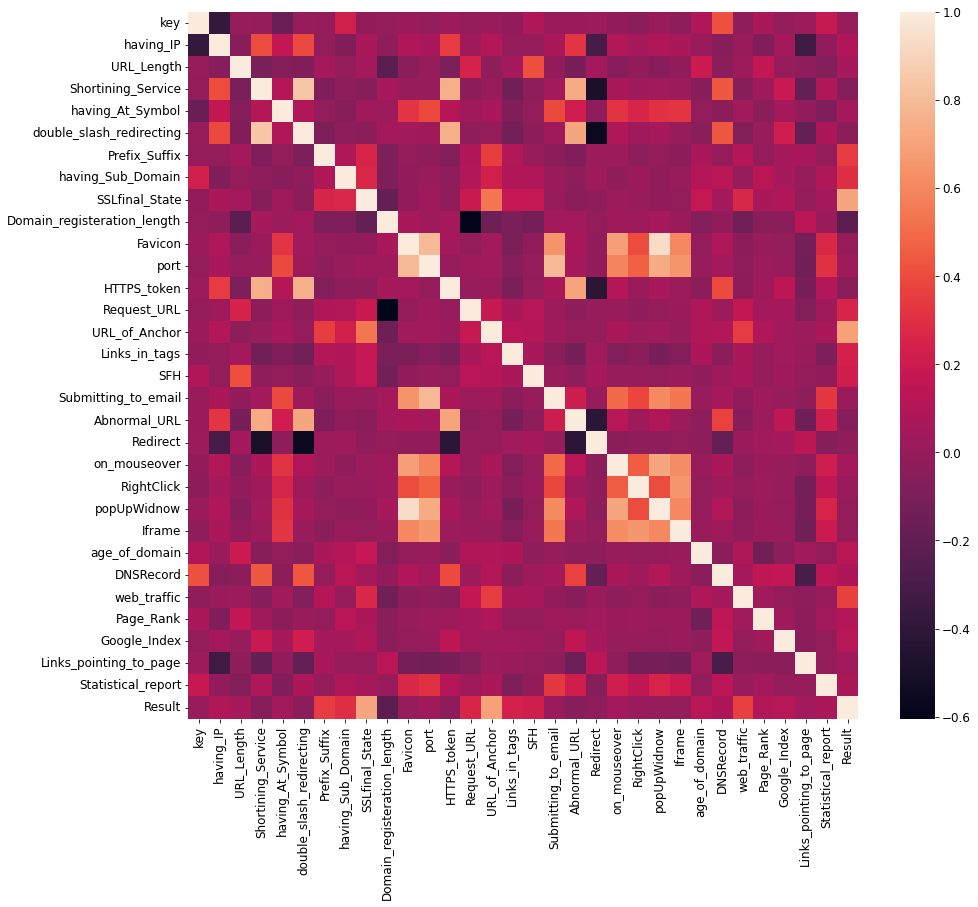

In [141]:
corr_matrix = org_train_dataset.corr()
#plt.matshow(corr_matrix)
#plt.show()
plt.figure(figsize=(15, 13))
sns.heatmap(corr_matrix)


### Correlation Value Plot

In [142]:
#corr_matrix.style.background_gradient(cmap='coolwarm').set_precision(2)
# Fill diagonal and upper half with NaNs
corr_matrix_temp = corr_matrix.copy()
mask = np.zeros_like(corr_matrix_temp, dtype=bool)
mask[np.triu_indices_from(mask)] = True
corr_matrix_temp[mask] = np.nan
corr_matrix_temp.style.background_gradient(cmap='coolwarm', axis=None, vmin=-1, vmax=1).highlight_null(
    null_color='#f1f1f1').set_precision(2)


C:\Users\saika\AppData\Local\Temp\ipykernel_15072\277405862.py:8: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  null_color='#f1f1f1').set_precision(2)


,key,having_IP,URL_Length,Shortining_Service,having_At_Symbol,double_slash_redirecting,Prefix_Suffix,having_Sub_Domain,SSLfinal_State,Domain_registeration_length,Favicon,port,HTTPS_token,Request_URL,URL_of_Anchor,Links_in_tags,SFH,Submitting_to_email,Abnormal_URL,Redirect,on_mouseover,RightClick,popUpWidnow,Iframe,age_of_domain,DNSRecord,web_traffic,Page_Rank,Google_Index,Links_pointing_to_page,Statistical_report,Result
key,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
having_IP,-0.38,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
URL_Length,0.00,-0.05,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Shortining_Service,-0.00,0.40,-0.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
having_At_Symbol,-0.18,0.16,-0.07,0.11,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
double_slash_redirecting,0.00,0.39,-0.08,0.84,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Prefix_Suffix,-0.01,-0.01,0.05,-0.09,-0.01,-0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
having_Sub_Domain,0.23,-0.08,-0.00,-0.03,-0.06,-0.03,0.09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
SSLfinal_State,-0.02,0.07,0.05,-0.06,0.03,-0.04,0.26,0.27,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
Domain_registeration_length,-0.01,-0.02,-0.22,0.06,0.02,0.04,-0.09,-0.09,-0.19,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


### Correlation of Result with input features

In [143]:
corr_matrix["Result"].sort_values(ascending=False)


Result                         1.000000
SSLfinal_State                 0.712543
URL_of_Anchor                  0.696394
web_traffic                    0.355581
Prefix_Suffix                  0.344660
having_Sub_Domain              0.296728
Request_URL                    0.254572
Links_in_tags                  0.238802
SFH                            0.217931
age_of_domain                  0.135198
Google_Index                   0.121896
Page_Rank                      0.102920
having_IP                      0.094027
DNSRecord                      0.081927
Statistical_report             0.068015
URL_Length                     0.059331
having_At_Symbol               0.050045
on_mouseover                   0.042180
Links_pointing_to_page         0.035003
port                           0.033971
Submitting_to_email            0.011981
RightClick                     0.004880
key                           -0.000854
popUpWidnow                   -0.002868
Favicon                       -0.003260


## Data Preparation for Model Training

In [144]:
org_train_dataset_features = org_train_dataset.iloc[:, 1:31].values
org_train_dataset_labels = org_train_dataset.iloc[:, 31].values

X_train, X_test, y_train, y_test = train_test_split(
    org_train_dataset_features, org_train_dataset_labels, test_size=0.10, random_state=42)


#### Some Classifiers what we might use later (ToDO)

In [145]:
skfolds = StratifiedKFold(n_splits=25, shuffle=True, random_state=RANDOM_STATE)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=RANDOM_STATE)

knn_clf = KNeighborsClassifier()

tree_clf = DecisionTreeClassifier(max_depth=5)

forest_clf = RandomForestClassifier(max_depth=5)

mlp_clf = MLPClassifier(alpha=0.001, hidden_layer_sizes=([100, 100, 100]))

svm_clf = SVC(kernel='linear', C=1.0, random_state=RANDOM_STATE)

# add naive bayes, autoencoder and xgboost


## Model Training and Comparison

### Base Evaluater (Unused)

In [146]:
def tuneEstimater(estimator, param_grid, cv, scoring, verbose, X_train, y_train):
    estimator_cl1 = clone(estimator)
    estimator_cl2 = clone(estimator)
    grid = GridSearchCV(estimator=estimator_cl1, param_grid=param_grid, cv=cv, scoring=scoring,
                        return_train_score=False, verbose=verbose)

    grid_search = grid.fit(X_train, y_train)
    accuracy = grid_search.best_score_ * 100
    print("Accuracy of tuned {} : {:.2f}%".format(estimator.__class__.__name__, accuracy))

    return    #print(grid_search.best_params_)
# will map a list of estimators and params

### KNN

In [147]:
k_range = list(range(1, 15))
param_grid = dict(n_neighbors=k_range, weights=['distance'])
  
grid = GridSearchCV(estimator=knn_clf, param_grid=param_grid, cv=skfolds, scoring='accuracy',
                    return_train_score=False, verbose=1, n_jobs=N_JOBS)
  
grid_search=grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ * 100
print(
    "Accuracy of KNN with best tuned parameters : {:.2f}%".format(accuracy))

Fitting 25 folds for each of 14 candidates, totalling 350 fits
{'n_neighbors': 6, 'weights': 'distance'}
Accuracy of KNN with best tuned parameters : 95.72%


### Linear Regressor

In [148]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
param_grid = dict(solver=solvers, penalty=penalty, C=c_values)
model = LogisticRegression()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skfolds, scoring='accuracy',
                    return_train_score=False, verbose=1, n_jobs=N_JOBS)

grid_search = grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ * 100
print(
    "Accuracy of LgRegg with best tuned parameters : {:.2f}%".format(accuracy))


Fitting 25 folds for each of 15 candidates, totalling 375 fits
{'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
Accuracy of LgRegg with best tuned parameters : 92.88%


### Ridge Classifier

In [149]:
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
param_grid = dict(alpha=alpha)
model = RidgeClassifier()

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skfolds, scoring='accuracy',
                    return_train_score=False, verbose=1, n_jobs=N_JOBS)

grid_search = grid.fit(X_train, y_train)

print(grid_search.best_params_)
accuracy = grid_search.best_score_ * 100
print(
    "Accuracy of Ridge Classifier with best tuned parameters : {:.2f}%".format(accuracy))


Fitting 25 folds for each of 10 candidates, totalling 250 fits
{'alpha': 0.1}
Accuracy of Ridge Classifier with best tuned parameters : 92.14%


### Random Forest

In [154]:
model = RandomForestClassifier()
n_estimators = [10, 50, 100, 150, 200, 300, 400]
max_features = ['sqrt', 'log2']
param_grid = dict(n_estimators=n_estimators, max_features=max_features)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=skfolds, scoring='accuracy',
                    return_train_score=False, verbose=100, n_jobs=N_JOBS)

grid_search = grid.fit(X_train, y_train)

print("Best Params: ", grid_search.best_params_)
accuracy = grid_search.best_score_ * 100
print(
    "Accuracy of RandomForestClassifier with best tuned parameters : {:.2f}%".format(accuracy))


Fitting 25 folds for each of 14 candidates, totalling 350 fits
Best Params:  {'max_features': 'log2', 'n_estimators': 100}
Accuracy of RandomForestClassifier with best tuned parameters : 97.01%


## Final Prediction (With Output generation)

### Tuned KNN Classifier(Unused)

In [151]:
def knnFinal(): 
    tuned_knn = KNeighborsClassifier(**grid_search.best_params_)
    final_y_preds = tuned_knn.fit(org_train_dataset_features, org_train_dataset_labels)

    test_df = org_test_dataset.iloc[ : , 1:]

    final_predictions = tuned_knn.predict(test_df.to_numpy())

    results = pd.DataFrame({'Key': org_test_dataset.iloc[:, 0], 'Result': final_predictions})

    return results



### Tuned Random Forest Classifier

In [152]:
def randomForestFinal():
    tuned_forest = RandomForestClassifier(max_features='log2', n_estimators=100)
    final_y_preds = tuned_forest.fit(
        org_train_dataset_features, org_train_dataset_labels)

    test_df = org_test_dataset.iloc[:, 1:]

    final_predictions = tuned_forest.predict(test_df.to_numpy())

    results = pd.DataFrame({'Key': org_test_dataset.iloc[:, 0], 'Result': final_predictions})

    return results


## Predicting the Original Test Dataset with Random Forest Classifier

In [153]:
results = randomForestFinal()

## Writing the results to a CSV file

In [ ]:
results.to_csv(SUBMISSION_RESULTS_PATH, index=False,  header=True)